# Classificação logística de dígitos

In [1]:
import matplotlib.pyplot as plt
from IPython import display
import torch
from torch import nn
from torch.utils.data import DataLoader
from dataset import load_mnist

ds_train, ds_valid = load_mnist()

In [2]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(28 * 28, 10)

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        return self.layer(x)


def train_step(model, dl_train, optim, loss_func):
    """
    Executa uma época de treinamento.
    """
    # Coloca o modelo em modo treinamento
    model.train()
    loss_log = 0.
    
    for imgs, targets in dl_train:
        optim.zero_grad()
        scores = model(imgs)
        # Calcula a loss de um batch
        loss = loss_func(scores, targets)
        # Calcula os gradientes
        loss.backward()
        # Dá um passo do gradiente descendente
        optim.step()

        loss_log += loss.detach() * imgs.shape[0]

    # Média da loss para todas as imagens
    loss_log /= len(dl_train.dataset)
    return loss_log.item()


def accuracy(scores, targets):
    pred = scores.argmax(dim=1)
    return (pred == targets).float().mean()


@torch.no_grad()
def valid_step(model, dl_valid, loss_func, perf_func):
    """
    `perf_func` mede a acurácia do modelo.
    """
    # Coloca o modelo em modo avaliação
    model.eval()
    loss_log = 0.
    perf_log = 0.
    
    for imgs, targets in dl_valid:
        scores = model(imgs)
        # Calcula a loss de um batch
        loss = loss_func(scores, targets)
        # Calcula a acurácia de um batch
        perf = perf_func(scores, targets)

        loss_log += loss * imgs.shape[0]
        perf_log += perf * imgs.shape[0]

    # Média da loss para todas as imagens
    loss_log /= len(dl_valid.dataset)
    # Média da acurácia para todas as imagens
    perf_log /= len(dl_valid.dataset)

    return loss_log.item(), perf_log.item()


def show_log(logger):
    epochs, train_losses, valid_losses, accs = zip(*logger)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))
    
    ax1.plot(epochs, train_losses, label="Train loss")
    ax1.plot(epochs, valid_losses, label="Validation loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(epochs, accs, label="Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()

    plt.tight_layout()
    display.clear_output(wait=True)
    plt.show()

    

def train(model, ds_train, ds_valid, bs, num_epochs, lr, perf_func):
    dl_train = DataLoader(ds_train, batch_size=bs, shuffle=True)
    dl_valid = DataLoader(ds_valid, batch_size=bs, shuffle=True)

    loss_func = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(model.parameters(), lr=lr)
    logger = []

    for epoch in range(num_epochs):
        loss_train = train_step(model, dl_train, optim, loss_func)
        loss_valid, perf = valid_step(model, dl_valid, loss_func, perf_func)
        logger.append((epoch, loss_train, loss_valid, perf))
        show_log(logger)

    return logger

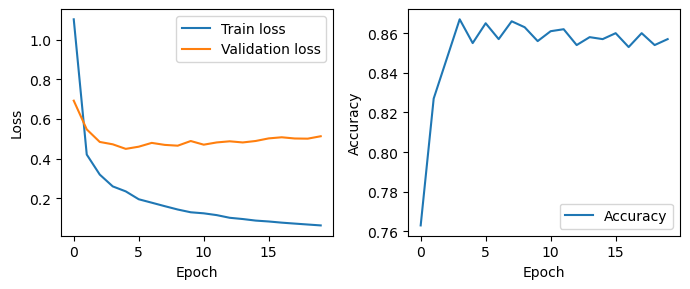

In [5]:
model = Model()
logger = train(model, ds_train, ds_valid, bs=64, num_epochs=20, lr=0.1, perf_func=accuracy)

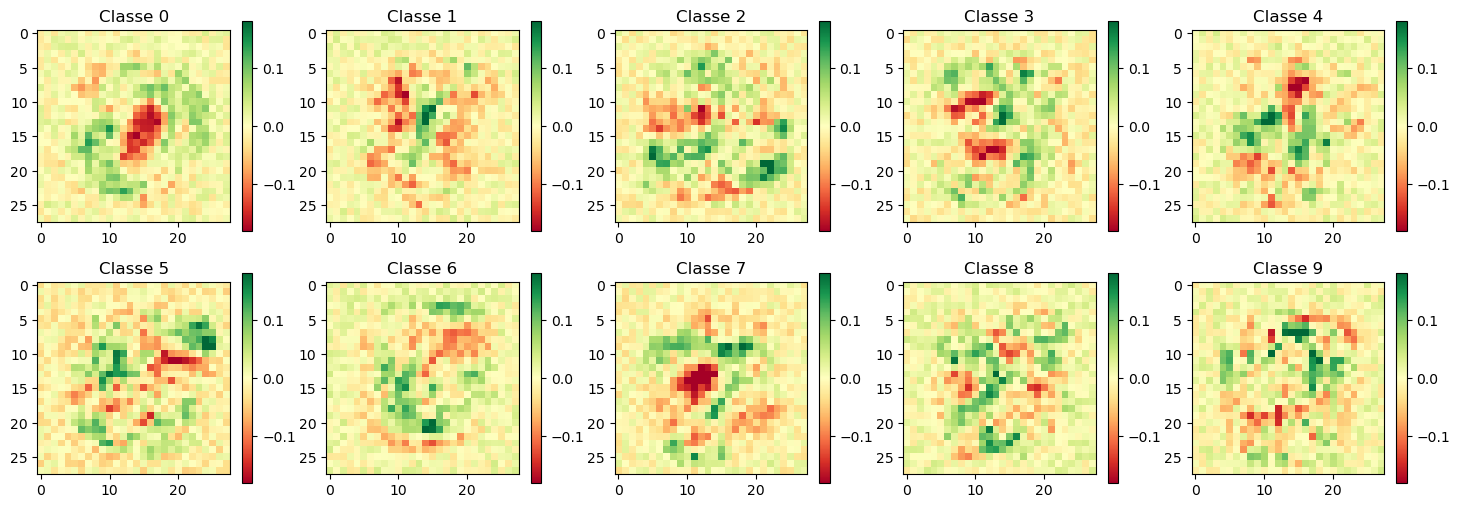

In [6]:
cn = plt.matplotlib.colors.CenteredNorm()
fig, axs = plt.subplots(2, 5, figsize=(18, 6))
axs = axs.reshape(-1)
for idx in range(10):
    weight = model.layer.weight[idx].detach().reshape(28, 28)
    plot = axs[idx].imshow(weight, "RdYlGn", norm=cn)
    axs[idx].set_title(f"Classe {idx}")
    plt.colorbar(plot, ax=axs[idx])